In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns

# Chapter 1: Data understanding and processing (EDA)

## 1.1 Get to know the data

In [3]:
path = "./HR_comma_sep.csv"
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
df.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
5,0.41,0.50,2,153,3,0,1,0,sales,low
6,0.10,0.77,6,247,4,0,1,0,sales,low
7,0.92,0.85,5,259,5,0,1,0,sales,low
8,0.89,1.00,5,224,5,0,1,0,sales,low
9,0.42,0.53,2,142,3,0,1,0,sales,low


Th dataset contains information about employees who worked in a company. These information included:
- Satisfactory Level
- Number of Project
- Average Monthly Hours
- Time Spend Company
- Promotion Last 5 Years
- Department
- Salary

The information was obtained mainly to predict employees retention - choose to stay or leave the company - defined by the "left" column 

## 1.2 Data cleaning and preprocessing
Include handling with:
- Inconsistent in col names
- Missing values
- Duplicate values
- Identify target variable and features
- Features importance and engineering
- Outliers
- Validation framework
- Label encoding with One-hot

### inconsistent column names

In [5]:
# normailize cols name
df.columns = df.columns.str.lower()
print(list(df.columns))

['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'work_accident', 'left', 'promotion_last_5years', 'department', 'salary']


### missing values

In [6]:
# missing values
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

$\to$ Luckily, no missing values were found

### duplicate values

In [7]:
# duplicate values
dups = df.duplicated().sum()
print(dups/df.shape[0])

0.2005467031135409


$\to$ 20% of the data were found to be duplicates. In this particular case, we will remove all the duplicates to prevent skewed, as each instances in the data represent an employee, and each of them should be treated independently for the best prediction result.

In [8]:
# handle duplication
print(f"Before: {df.shape}")
df = df.drop_duplicates(keep='first')
print(f"After: {df.shape}")

Before: (14999, 10)
After: (11991, 10)


### obtain categorical and numerical features

In [9]:
# get categorical features
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical.extend(["work_accident", "promotion_last_5years"])

# get numerical features
numerical = list(df.drop(columns=categorical).columns)
numerical.remove("left")

print(categorical, numerical)

['department', 'salary', 'work_accident', 'promotion_last_5years'] ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']


- Target is: 'left'
- Categorical features include: 'department', 'salary', 'work_accident', 'promotion_last_5years'
- Numerical features include: 'satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company'

### feature importance and engineering

In [10]:
# explore categorical features with mutual info
for col in categorical:
    print(df[col].value_counts(), "\n")
    print(f"Mutual info between retention and {col}: {mutual_info_score(df.left, df[col])}", "\n")

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64 

Mutual info between retention and department: 0.0009237527382885066 

salary
low       5740
medium    5261
high       990
Name: count, dtype: int64 

Mutual info between retention and salary: 0.008497990094004336 

work_accident
0    10141
1     1850
Name: count, dtype: int64 

Mutual info between retention and work_accident: 0.00969738527197149 

promotion_last_5years
0    11788
1      203
Name: count, dtype: int64 

Mutual info between retention and promotion_last_5years: 0.001356175449427931 



$\to$ Based on the result of mutual information, it is likely that salary and work_accident are more of potential features to predict employee retention than the rest. Hence, we will include these in the models.

In [11]:
# explore numerical features with correlation matrix
df[numerical].corrwith(df.left)

satisfaction_level     -0.350558
last_evaluation         0.013520
number_project          0.030928
average_montly_hours    0.070409
time_spend_company      0.173295
dtype: float64

$\to$ The correlation matrix tells us that, only features like satisfaction_level, time_spend_company, and average_monthly_hours are likely affected employee retention. Hence, we will also include them in the models, and save the others for further investigation.

In [12]:
# features will be used in prediction
categorical = ["salary", "work_accident"]
numerical = ["satisfaction_level", "time_spend_company", "average_montly_hours"]

### outliers

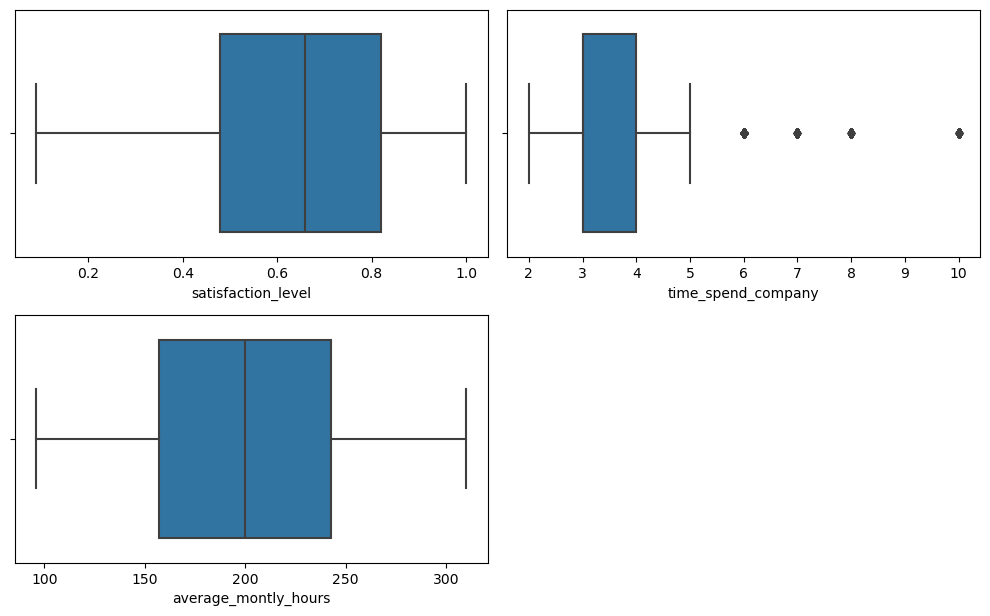

In [13]:
# detect outliers for numerical values
plt.figure(figsize=(10, 15))
for i, col in enumerate(numerical):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(df, x=col)
plt.tight_layout()
plt.show()

$\to$ From the boxplots, we can observe that time_spend_company varible contains multiple outilers that need to be addressed. But before we can decide wheter or not to remove outliers, it is important to first investigate the reason behind the existence of these values. And since some models are more sensitive to outliers than other, it also depends on the type of models we choose.

### validation framework
Setting up a validation process includes:
- Train data (60%)
- Validation data (20%)
- Test data (20%)

In [14]:
# spliting data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)
len(df_train), len(df_val), len(df_test)

(7194, 2398, 2399)

In [15]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# obtain target values
y_train = df_train.left.values
y_val = df_val.left.values
y_test = df_test.left.values

for i in [df_train, df_val, df_test]:
    del i["left"]

### one-hot label encoding
Using DictVectorizer perform one-hot encoding on the data without alternate original one

In [16]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[df_train.columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[df_val.columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[df_test.columns].to_dict(orient='records')
X_test = dv.transform(test_dict)


Gaussian NB Training Results:
Training Accuracy: 0.796

Training Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      9134
           1       0.56      0.73      0.63      2865

    accuracy                           0.80     11999
   macro avg       0.73      0.77      0.74     11999
weighted avg       0.82      0.80      0.80     11999


Multinomial NB Training Results:
Training Accuracy: 0.769

Training Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      9134
           1       0.53      0.26      0.35      2865

    accuracy                           0.77     11999
   macro avg       0.67      0.59      0.60     11999
weighted avg       0.74      0.77      0.74     11999


Bernoulli NB Training Results:
Training Accuracy: 0.751

Training Classification Report:
              precision    recall  f1-score   support

           0       0

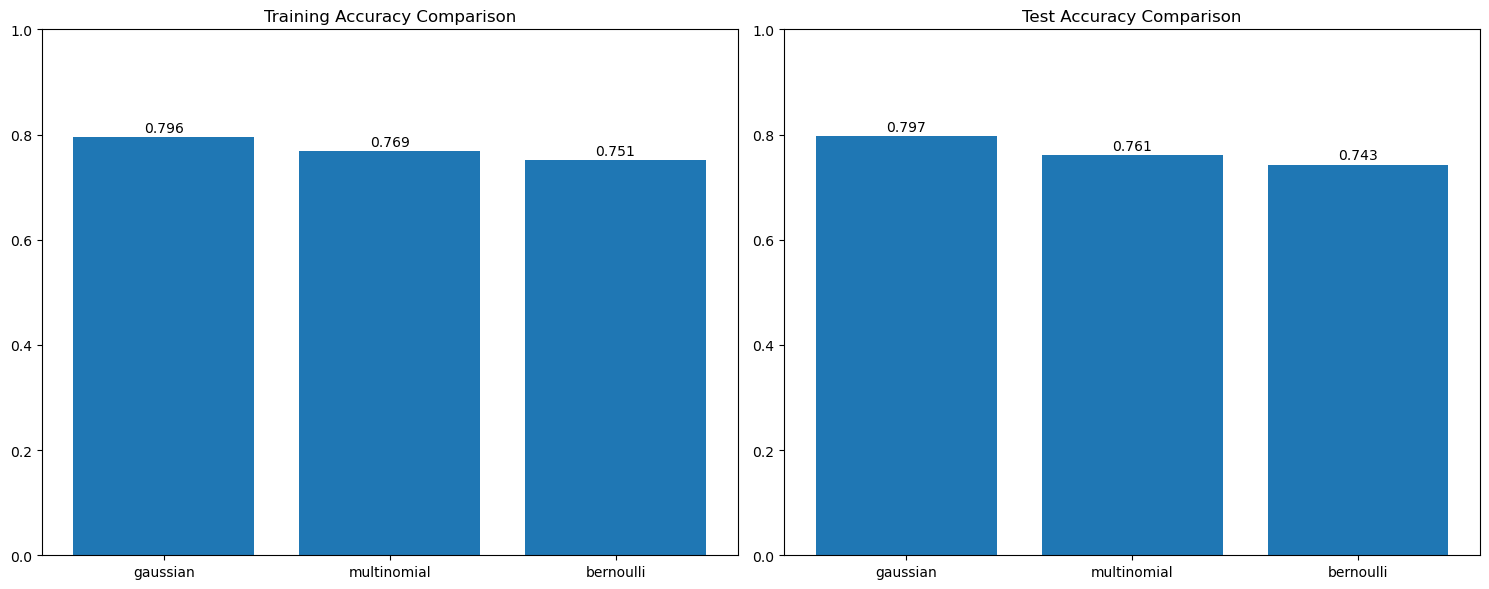

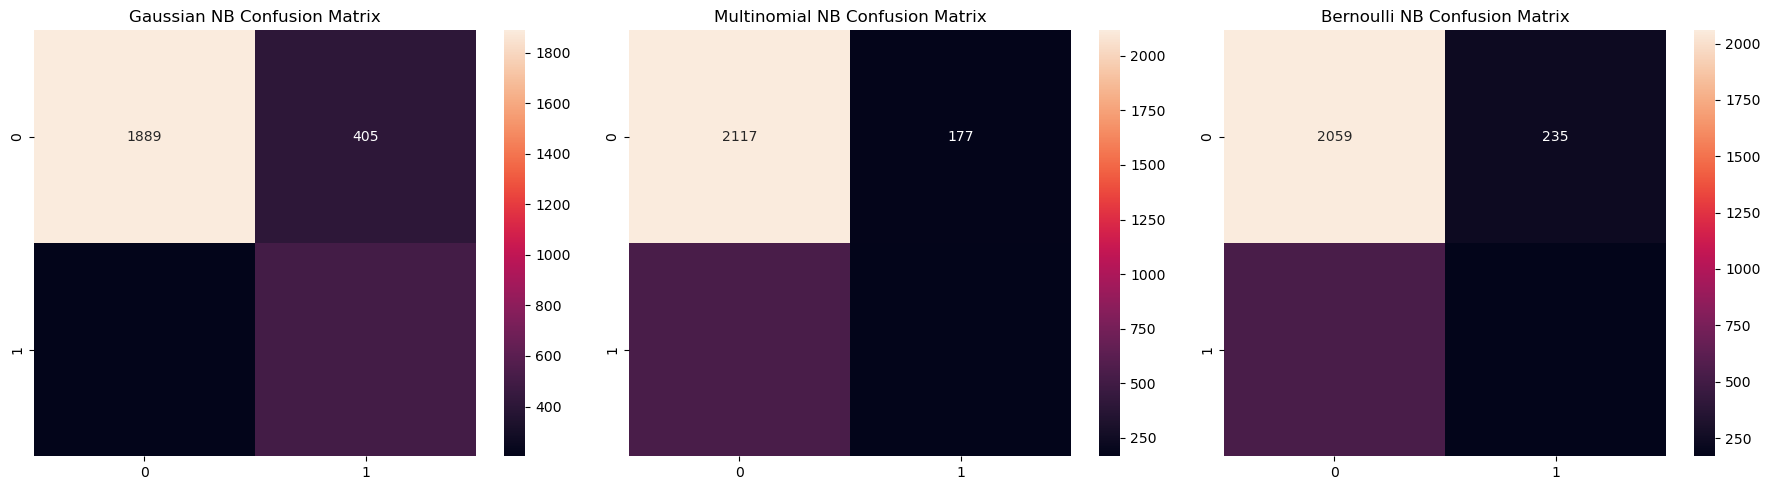

In [19]:
class HRNaiveBayesVariants:
    def __init__(self):
        self.models = {
            'gaussian': GaussianNB(),
            'multinomial': MultinomialNB(),
            'bernoulli': BernoulliNB()
        }
        self.scalers = {}
        self.label_encoders = {}
        
    def load_and_prepare_data(self, filepath):
        """
        Load and prepare HR dataset
        """
        # Load data
        df = pd.read_csv(filepath)
        
        # Identify categorical columns - update these based on your actual categorical columns
        self.categorical_features = ['Department', 'salary']
        
        # Separate features and target
        X = df.drop('left', axis=1)
        y = df['left']
        
        return train_test_split(X, y, test_size=0.2, random_state=42)
    
    def preprocess_data(self, X):
        """
        Preprocess the HR dataset
        """
        X_processed = X.copy()
        
        # Handle categorical features
        for feature in self.categorical_features:
            if feature not in self.label_encoders:
                self.label_encoders[feature] = LabelEncoder()
                X_processed[feature] = self.label_encoders[feature].fit_transform(X_processed[feature])
            else:
                X_processed[feature] = self.label_encoders[feature].transform(X_processed[feature])
        
        # Scale numerical features
        numerical_features = [col for col in X_processed.columns if col not in self.categorical_features]
        
        # Ensure all features are numeric before scaling
        X_processed[numerical_features] = X_processed[numerical_features].astype(float)
        
        if not self.scalers:
            self.scalers['standard'] = StandardScaler()
            X_processed[numerical_features] = self.scalers['standard'].fit_transform(X_processed[numerical_features])
        else:
            X_processed[numerical_features] = self.scalers['standard'].transform(X_processed[numerical_features])
            
        return X_processed
    
    def train_models(self, X_train, y_train):
        """
        Train all Naïve Bayes variants on HR data
        """
        # Preprocess training data
        X_train_processed = self.preprocess_data(X_train)
        
        # Train each model variant
        results = {}
        for name, model in self.models.items():
            # Convert data to float type for MultinomialNB
            if name == 'multinomial':
                # Ensure all values are non-negative for MultinomialNB
                X_train_processed_mnb = X_train_processed - X_train_processed.min()
            else:
                X_train_processed_mnb = X_train_processed
                
            model.fit(X_train_processed_mnb, y_train)
            train_pred = model.predict(X_train_processed_mnb)
            results[name] = {
                'training_accuracy': accuracy_score(y_train, train_pred),
                'training_report': classification_report(y_train, train_pred)
            }
            print(f"\n{name.capitalize()} NB Training Results:")
            print(f"Training Accuracy: {results[name]['training_accuracy']:.3f}")
            print("\nTraining Classification Report:")
            print(results[name]['training_report'])
        
        return results
    
    def evaluate_models(self, X_test, y_test):
        """
        Evaluate all models on HR test data
        """
        X_test_processed = self.preprocess_data(X_test)
        results = {}
        
        for name, model in self.models.items():
            if name == 'multinomial':
                # Ensure all values are non-negative for MultinomialNB
                X_test_processed_mnb = X_test_processed - X_test_processed.min()
            else:
                X_test_processed_mnb = X_test_processed
                
            y_pred = model.predict(X_test_processed_mnb)
            y_prob = model.predict_proba(X_test_processed_mnb)
            
            results[name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'classification_report': classification_report(y_test, y_pred),
                'confusion_matrix': confusion_matrix(y_test, y_pred),
                'probabilities': y_prob
            }
            
            print(f"\n{name.capitalize()} NB Test Results:")
            print(f"Test Accuracy: {results[name]['accuracy']:.3f}")
            print("\nClassification Report:")
            print(results[name]['classification_report'])
            print("\nConfusion Matrix:")
            print(results[name]['confusion_matrix'])
            
        return results
    
    def plot_results(self, train_results, test_results):
        """
        Plot comparison of model performances for HR prediction
        """
        # Prepare data for plotting
        model_names = list(self.models.keys())
        train_acc = [train_results[name]['training_accuracy'] for name in model_names]
        test_acc = [test_results[name]['accuracy'] for name in model_names]
        
        # Set up the plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot training results
        ax1.bar(model_names, train_acc)
        ax1.set_title('Training Accuracy Comparison')
        ax1.set_ylim(0, 1)
        for i, v in enumerate(train_acc):
            ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')
            
        # Plot test results
        ax2.bar(model_names, test_acc)
        ax2.set_title('Test Accuracy Comparison')
        ax2.set_ylim(0, 1)
        for i, v in enumerate(test_acc):
            ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')
            
        plt.tight_layout()
        plt.show()
        
        # Plot confusion matrices
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        for i, (name, results) in enumerate(test_results.items()):
            sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', ax=axes[i])
            axes[i].set_title(f'{name.capitalize()} NB Confusion Matrix')
        plt.tight_layout()
        plt.show()

def main():
    # Initialize the class
    hr_nb = HRNaiveBayesVariants()
    
    # Load and split the data
    X_train, X_test, y_train, y_test = hr_nb.load_and_prepare_data('HR_comma_sep.csv')
    
    # Train models and get training results
    train_results = hr_nb.train_models(X_train, y_train)
    
    # Evaluate models and get test results
    test_results = hr_nb.evaluate_models(X_test, y_test)
    
    # Plot comparisons
    hr_nb.plot_results(train_results, test_results)

if __name__ == "__main__":
    main()